In [ ]:
# SVM
# Logistic Regression
# adaboost

## Imports

In [ ]:
from google.colab import files
import io
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

In [ ]:
  uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


## Basic Preprocessing

In [ ]:
train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test_df = pd.read_csv(io.BytesIO(uploaded['test.csv']))

alldat = train_df.append(test_df, sort=True)

In [ ]:
# Price and Bathrooms
print(alldat["Bathrooms_text"].unique())
alldat["Price"] = alldat["Price"].replace('[\$,]', '', regex=True).astype(float)

['1 bath' '1 private bath' '2 baths' '1.5 baths' '3 baths' '2.5 baths'
 '6 baths' '5 baths' '1 shared bath' '3.5 baths' '1.5 shared baths'
 '4.5 baths' '2.5 shared baths' '4 baths' 'Private half-bath' 'Half-bath'
 '9 baths' '2 shared baths' '6.5 baths' '0 shared baths' '0 baths'
 '5.5 baths' '7 baths' '7.5 baths']


In [ ]:
cat_names = ["Host_response_time",
             "Host_is_superhost",
             "Host_has_profile_pic",
             "Host_identity_verified",
             "Neighbourhood",
             "Property_type",
             "Room_type",
             "Instant_bookable",
             "Month",
             "Parking",
             "Balcony",
             "Bathrooms_text"] #choosing to treat as categorical because it is not unreasonable to believe
                               #a consumer would treat regular vs private vs shared baths and half baths differently,
                               # and it is not unreasonable to expect there to be an interaction between these and the
                               # numeric value of of baths
                               # in a future analysis, i would want to test these assumptions


num_names = ["Accommodates",
             "Bedrooms",
             "Beds",
             "Essentials",
             "Cooking",
             "Number_of_reviews",
             "Review_scores_rating",
             "Price"]

In [ ]:
print(alldat[cat_names].isna().sum())

Host_response_time        1151
Host_is_superhost          112
Host_has_profile_pic       112
Host_identity_verified     112
Neighbourhood                0
Property_type                0
Room_type                    0
Instant_bookable             0
Month                        0
Parking                      0
Balcony                      0
Bathrooms_text               0
dtype: int64


I'm going to treat all categorical missing variables as having a categorical value, as the airbnb consumer likely uses the fact that the information is missing in their determinination of whether or not to book.

In [ ]:
alldat["Host_response_time"] = alldat["Host_response_time"].fillna("Missing")
alldat["Host_is_superhost"] = alldat["Host_is_superhost"].fillna("Missing")
alldat["Host_has_profile_pic"] = alldat["Host_has_profile_pic"].fillna("Missing")
alldat["Host_identity_verified"] = alldat["Host_identity_verified"].fillna("Missing")

In [ ]:
print(alldat[num_names].isna().sum())

Accommodates              0
Bedrooms                734
Beds                     22
Essentials                0
Cooking                   0
Number_of_reviews         0
Review_scores_rating    669
Price                     0
dtype: int64


I'm going to make some informed decisions that are going to impact the outcome. I believed that having an "NA" review (Review_scores_rating == na) is categorically different than having any specific rating. As such, we impute Review_scores_rating for NAs to be the the mean value, but in addition create a new feature that is = 1 when Review_scores_rating is missing to signifiy the lack of reviews interaction.

For the missing bedrooms and beds, I do a similar thing where I impute the mean and create an indicator for if the value was missing.[link text](https://)

In [ ]:
missing_scores = alldat[alldat["Review_scores_rating"].isna()]
print(missing_scores["Number_of_reviews"].value_counts())
print(alldat["Bedrooms"].value_counts())
missing_beds = alldat[alldat["Bedrooms"].isna()]
print(missing_beds["Beds"].value_counts())
print(missing_beds["Beds"].isna().sum())

0    669
Name: Number_of_reviews, dtype: int64
1.0    4685
2.0    2418
3.0    1332
4.0     503
5.0     134
6.0      66
7.0      23
8.0      12
9.0       4
Name: Bedrooms, dtype: int64
1.0    467
2.0    202
0.0     44
3.0     11
4.0      4
Name: Beds, dtype: int64
6


In [ ]:
bedrooms = alldat["Bedrooms"]
beds = alldat["Beds"]
ratings = alldat["Review_scores_rating"]
alldat["Missing_Bedrooms"] = bedrooms.isna()
alldat["Missing_Beds"] = beds.isna()
alldat["Missing_Ratings"] = ratings.isna()
alldat["Bedrooms"] = bedrooms.fillna(np.mean(bedrooms))
alldat["Beds"] = beds.fillna(np.mean(beds))
alldat["Review_scores_rating"] = ratings.fillna(np.mean(ratings))
alldat["Review_num_score"] = alldat["Review_scores_rating"]*alldat["Number_of_reviews"]
num_names = num_names + ["Review_num_score"]

In [ ]:
df = pd.get_dummies(alldat, prefix = cat_names, columns = cat_names)
for feature in num_names:
    df[feature] = pd.to_numeric(df[feature], errors = 'coerce')

fintrain = df.head(len(train_df))
fintest = df.tail(len(test_df))

## Basic Data Vis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0b8a70410>,
      dtype=object)

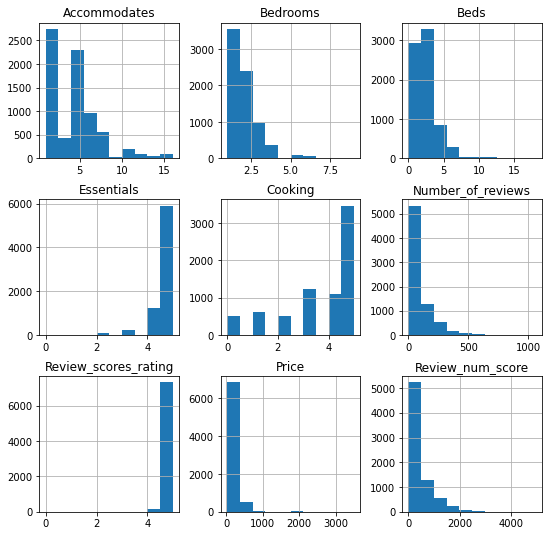

In [ ]:
fintrain.hist(column = num_names, figsize= (9, 9))

From these histograms, we learn a bit about our numerical variables in our dataset. There is nothing really out of the ordinary here. There are lower bedrooms and beds that seem fairly correlated and are both skewed right, which in turn looks fairly similarly to the "Acommodates" variable. Most bnbs have at least 4 essentials, although, there is a good bit of variability in cooking. This might be a determining factor for some consumers. Number of reviews has a lower mean as well, a very high mode at 1, and something we might want to be concerned about as it would heavily bias the review scores rating upward. As such, we add an interaction term between rating and number of reviews in the above code. Finally, we can see there is a very heavy bias for lower prices, which makes sense for airbnbs.

[Text(0, 0, 'Accommodates'),
 Text(0, 0, 'Bedrooms'),
 Text(0, 0, 'Beds'),
 Text(0, 0, 'Essentials'),
 Text(0, 0, 'Cooking'),
 Text(0, 0, 'Number_of_reviews'),
 Text(0, 0, 'Review_scores_rating'),
 Text(0, 0, 'Price'),
 Text(0, 0, 'Review_num_score')]

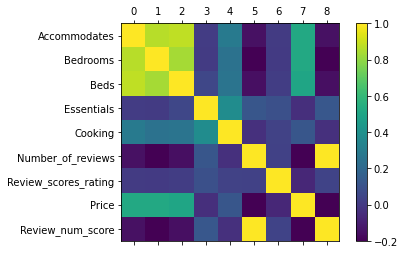

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
train_numerics = fintrain[num_names]
axs=ax.matshow(train_numerics.corr())
fig.colorbar(axs)
ticks = np.arange(0,9,1)
ax.set_yticks(ticks)
ax.set_yticklabels(num_names)

From this correlation matrix, we can see that "Accomodates", "Bedrooms", and "Beds" are all very correlated with one another. This makes a lot of sense given they are all features that relay information about housing at a bnb. However, we will not opt to reduce dimensions here for several reasons. First, the actual number of bedrooms might be of importance to a group of people trying to book an airbnb for privacy concerns. Additionally, the number "accomodates" can be enforced by airbnb hosts and so therefore is something that consumers have to abide by regardless of how many people think they can bring into the bnb. Hence, we keep all these variables indepedent. Finally, we see number of reviews and review num score are highly correlated. This makes sense as they were engineered as such to capture an interaction.

## Models!!

In [ ]:
X = fintrain.drop(['id','Decision'], axis=1).to_numpy()
y = fintrain['Decision'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

### SVM

In [ ]:
params_svm = {
    'C' : [1, 0.1, 10],
    'gamma' : [1,1/X_train.shape[1], 2/X_train.shape[1],1/(2*X_train.shape[1]),20/(X_train.shape[1])]
}

svm = GridSearchCV(
    SVC(random_state = 0, kernel="rbf"),
    param_grid = params_svm,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = 10
)

svm.fit(X_train,y_train)
# 4 minutes 13  seconds

GridSearchCV(cv=5, estimator=SVC(random_state=0), n_jobs=10,
             param_grid={'C': [1, 0.1, 10],
                         'gamma': [1, 0.007692307692307693,
                                   0.015384615384615385, 0.0038461538461538464,
                                   0.15384615384615385]},
             scoring='accuracy')

In [ ]:
print("Parameters: " + str(svm.best_params_))
print("Best Accuracy: " + str(svm.best_score_))

Parameters: {'C': 10, 'gamma': 0.15384615384615385}
Best Accuracy: 0.7657305383355957


In [ ]:
tr_svm_predic = svm.predict(X_train)
test_svm_predic = svm.predict(X_test)

print("SVM Training Confusion Matrix")
tr_svm_conf = confusion_matrix(y_train,tr_svm_predic)
print(tr_svm_conf)
print("SVM Training Accuracy: " + str(np.trace(tr_svm_conf)/X_train.shape[0]))
print("\nSVM Testing Confusion Matrix")
test_svm_conf = confusion_matrix(y_test,test_svm_predic)
print(test_svm_conf)
print("SVM Testing Accuracy: " + str(np.trace(test_svm_conf)/X_test.shape[0]))

SVM Training Confusion Matrix
[[2188    0]
 [   0 3788]]
SVM Training Accuracy: 1.0

SVM Testing Confusion Matrix
[[228 320]
 [ 18 929]]
SVM Testing Accuracy: 0.7739130434782608


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


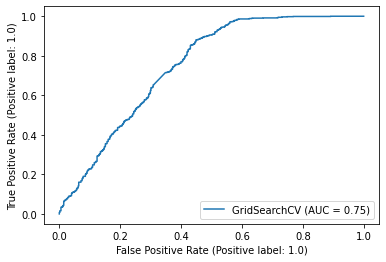

In [ ]:
plot_roc_curve(svm, X_test, y_test)

We observe pretty good CV accuracy at almost 76.6%, however, when we observe the training and testing accuracy, even though they are not substantially different, it is clear that we are overfitting. The training accuracy hits around 100% while the testing accuracy is at 77.39%. After messing around with some other gamma and C values individually, it's clear that increasing gamma's value increases both training and testing accuracy, but also increases overfitting substantially. It's also clear that our model is getting a lot more false positives and so therefore choosing to predict positive more often than it should.

Based on our ROC curve, we can see that this has an AUC of .75, so it has a good bit of distance from 1 and we could definitely stand to improve the overfitting if we were to decrease gamma. However, this would also decrease accuracy and therefore we would have to weigh that tradeoff based on the context.

## Logistic Regression

In [ ]:
params_logit = {
    'penalty' : ['l2', 'none'],
    'C' : [0.01, 0.1, 1, 10, 100]
}

logit = GridSearchCV(
    LogisticRegression(random_state = 420, solver="newton-cg"),
    param_grid = params_logit,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = 10
)

logit.fit(X_train, y_train)
# 3m 44s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=420, solver='newton-cg'),
             n_jobs=10,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2', 'none']},
             scoring='accuracy')

In [ ]:
print("Parameters: " + str(logit.best_params_))
print("Best Accuracy: " + str(logit.best_score_))

Parameters: {'C': 100, 'penalty': 'l2'}
Best Accuracy: 0.69946292383258


In [ ]:
tr_logit_predic = logit.predict(X_train)
test_logit_predic = logit.predict(X_test)

print("Logit Training Confusion Matrix")
tr_logit_conf = confusion_matrix(y_train,tr_logit_predic)
print(tr_logit_conf)
print("Logit Training Accuracy: " + str(np.trace(tr_logit_conf)/X_train.shape[0]))
print("\nLogit Testing Confusion Matrix")
test_logit_conf = confusion_matrix(y_test,test_logit_predic)
print(test_logit_conf)
print("Logit Testing Accuracy: " + str(np.trace(test_logit_conf)/X_test.shape[0]))

Logit Training Confusion Matrix
[[ 974 1214]
 [ 525 3263]]
Logit Training Accuracy: 0.7090026773761714

Logit Testing Confusion Matrix
[[264 284]
 [111 836]]
Logit Testing Accuracy: 0.7357859531772575


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


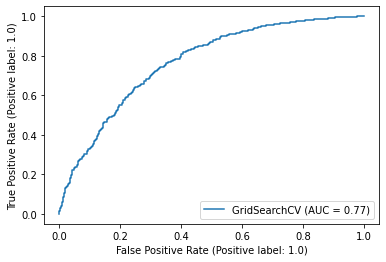

In [ ]:
plot_roc_curve(logit, X_test, y_test)

We observe similar but lower CV accuracy for our logit regression at 69.9% with an L-2 penalty and a regularization parameter of 100. This regularization ends up being really good for us because, as we can see, we get higher testing accuracy than we do training accuracy, so we can be fairly certain we are not overfitting. In addition, given that this is only marginally lower accuracy than our wildly overfit SVM and comes with far more interpretability, I would be inclined to use this model more for decisions that matter as we can at least understand why the model makes the decisions it does. Once again, however, just like the SVM, it tends to massively overpredict false positives.

Our ROC curve is only marginally better with an AUC of 0.77.

## Adaboost

In [ ]:
params_ada = {
    'n_estimators' : [10, 50, 100],
    'learning_rate' : [0.1, 0.5, 1, 5, 10]
}

ada = GridSearchCV(
    AdaBoostClassifier(random_state = 13050),
    param_grid = params_ada,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = 10
)

ada.fit(X_train, y_train)
# 3m 7s

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=13050), n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.5, 1, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

In [ ]:
print("Parameters: " + str(ada.best_params_))
print("Best Accuracy: " + str(ada.best_score_))

Parameters: {'learning_rate': 1, 'n_estimators': 100}
Best Accuracy: 0.7282446369348315


In [ ]:
tr_ada_predic = ada.predict(X_train)
test_ada_predic = ada.predict(X_test)

print("AdaBoost Training Confusion Matrix")
tr_ada_conf = confusion_matrix(y_train,tr_ada_predic)
print(tr_ada_conf)
print("AdaBoost Training Accuracy: " + str(np.trace(tr_ada_conf)/X_train.shape[0]))
print("\nAdaBoost Testing Confusion Matrix")
test_ada_conf = confusion_matrix(y_test,test_ada_predic)
print(test_ada_conf)
print("AdaBoost Testing Accuracy: " + str(np.trace(test_ada_conf)/X_test.shape[0]))

AdaBoost Training Confusion Matrix
[[1146 1042]
 [ 484 3304]]
AdaBoost Training Accuracy: 0.7446452476572959

AdaBoost Testing Confusion Matrix
[[280 268]
 [124 823]]
AdaBoost Testing Accuracy: 0.7377926421404682


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


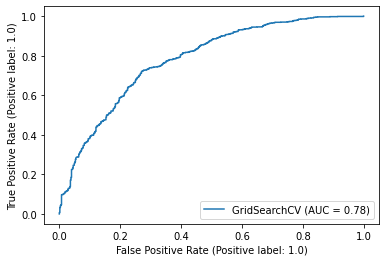

In [ ]:
plot_roc_curve(ada, X_test, y_test)

Here we see 72.8% as our best CV accuracy which is higher than Logistic Regression but lower than SVM. When we observe our training and test accuracies, we see there isn't much of a difference, so we can be fairly confident we are not overfitting, which makes sense as AdaBoost tends not to overfit. Our testing accuracy is marginally higher than that of Logistic Regression and slightly lower than that of SVM. We also tend to, once again, make twice as many false positives than negatives

Our ROC curve is once again marginally better at the best with an AUC of 0.78.

## Submission

In [ ]:
X_f = fintest.drop(['Decision', 'id'], axis=1).to_numpy()
pred_ada = ada.predict(X_f)

In [ ]:
final = {'id': test_df['id'],
        'Decision': pred_ada}
final_df = pd.DataFrame(final)
final_df.to_csv("finalsubmit.csv",index=False)